Residential Property Data and Presidential Election Results - Data Preprocessing and Feature Engineering

We will be modeling the results of the 2016 presidential election in King County to find out how successfully a learning algorithm can predict the results of an election based on the housing characteristics of voting precincts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 350)

-----

## The Data

We'll use two datasets: results from the King County Department of Elections and housing data from the King County Assessor.  

Election results are reported by precincts, which are groups of up to 1000 voters. The precincts are represented by polygons with areas that are inversely proportional to population density. The raw data is a long format CSV with a row for each observation (ie "votes for Trump" or "number of registered voters") in each precinct.

The Assessor's database extract comes in the form of several different tables. To summarize housing characteristcs by precinct we will need several: parcel data, residential buildings (up to 3 units), apartment complexes (4+ units), condominium units, and condominium complexes. Some of these tables contain one record per parcel. We need to aggregate these to the parcel level. Finally, we'll summarize the housing characteristics for each voting precinct. These derived summary statistics will be the bulk of our feature set for model fitting.

In [2]:
# read the election results

contest = pd.read_csv('16results.csv')

# read parcel areas file

areas = pd.read_csv('parcel_areas.csv')

# read assessor lookup table for category details

lookup = pd.read_csv('cd/EXTR_Lookup.csv', engine="python")

# read parcel, residential, apartment, condo, and real property account files

parcel = pd.read_csv('cd/EXTR_Parcel.csv', engine="python")
res = pd.read_csv('cd/EXTR_ResBldg.csv', engine="python")
apt = pd.read_csv('cd/EXTR_AptComplex.csv', engine="python")
condo = pd.read_csv('cd/EXTR_CondoComplex.csv', engine="python")
cunits = pd.read_csv('cd/EXTR_CondoUnit2.csv', engine="python",
                     error_bad_lines=False, warn_bad_lines=True)
value = pd.read_csv('cd/EXTR_RPAcct_NoName.csv')

Skipping line 61722: ',' expected after '"'
Skipping line 63236: ',' expected after '"'


In [3]:
# Create a dictionary of the lookup table references for each categorical variable

usedcols = {
    'res': {
        'Condition': 83,
        'BldgGrade': 82
    },
    'cunits': {
        'UnitType': 150,
        'UnitQuality': 151,
        'UnitLocation': 152,
        'Condition': 155,
        'ViewMountain': 157,
        'ViewLakeRiver': 157,
        'ViewCityTerritorial': 157,
        'ViewPugetSound': 157,
        'ViewLakeWaSamm': 157,
        'ComplexType': 143,
        'ProjectLocation': 98,
        'ProjectAppeal': 99,
        'ConstrClass': 97,
        'BldgQuality': 96,
        'Laundry': 89,
        'CondoLandType': 145
    },
    'apt': {
        'ProjectLocation': 98,
        'ProjectAppeal': 99,
        'ConstrClass': 97,
        'BldgQuality': 96,
        'Laundry': 89,
        'Condition': 83
    },
    'parcel': {
        'WaterSystem': 56,
        'SewerSystem': 57,
        'StreetSurface': 60,
        'MtRainier': 58,
        'Olympics': 58,
        'Cascades': 58,
        'Territorial': 58,
        'SeattleSkyline': 58,
        'PugetSound': 58,
        'LakeWashington': 58,
        'LakeSammamish': 58,
        'SmallLakeRiverCreek': 58,
        'OtherView': 58,
        'WfntLocation': 50,
        'TrafficNoise': 95
    }
}


def replacecats(df, table):
    """Replace encoded categorical values in a dataframe with actual category names."""
    for key, value in usedcols[table].items():
        # load the values to find and replace for each column
        x = lookup[lookup['LUType'] == value]['LUItem'].tolist()
        y = lookup[lookup['LUType'] == value]['LUDescription'].tolist()
        y = [z.replace(' ', '').replace('/', '').replace('(', '').replace(')',
                                                                          '').replace('+', '').replace(',', '') for z in y]

        # apply to the current column if it exists
        try:
            df[key] = df[key].replace(x, y)
        except:
            pass

----

#### Parcel Areas
Because some parcels overlap with precincts, we are also using with a table of the areas of every parcel-precinct slice. Many of these span multiple precincts. We are assuming that almost every residential parcel is entirely (or close to entirely) within a single precinct, but we need to confirm that by looking at a histogram of the relative proportional areas of the slices of each parcel. As we can see, the slices are nearly all slivers: either above 99% or below 1% of parcel areas. What that means is that we're probably not going to have to worry about apportioning parcel statistics between different precincts. But we can check to make sure.

In [4]:
# Make an array of parcel IDs contained in our residential tables
# areas = pd.read_csv('parcel_areas.csv')
# pins = res['pin'].append(apt['pin']).append(cunits['pin']).astype(str).unique()

In [5]:
# areas = areas.loc[areas['pin'].isin(pins)]

In [6]:
areas['total'] = areas.groupby(['name']).transform('sum')['area']
areas['share'] = areas['area'] / areas['total']
areas['counter'] = 1
sum_areas = areas.groupby(['pin', 'name']).agg(
    {'area': 'sum', 'counter': 'sum'})
sum_areas['c'] = sum_areas.groupby('pin').transform('sum')['counter']
sum_areas['subarea'] = sum_areas.groupby(['pin']).transform('sum')['area']
sum_areas['subshare'] = sum_areas['area'] / sum_areas['subarea']
sum_areas.reset_index(inplace=True)

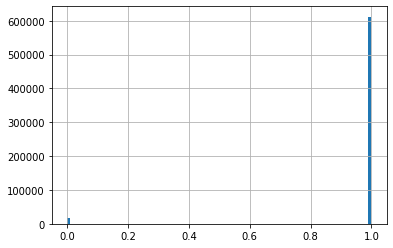

In [7]:
sum_areas['subshare'].hist(bins=100)
plt.title = 'Share of parcel area by precinct slice'
plt.show()

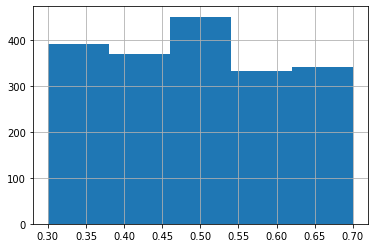

In [8]:
sum_areas[(sum_areas.subshare < .7) & (sum_areas.subshare > .3)
          ].sort_values(by=['pin', 'name']).subshare.hist(bins=5)

There are around 1000 (of ~600,000) parcels with a more even split than this 70/30 threshold. A single parcel will not throw off a whole precinct's totals, so we are going to assign each precinct to a specific precinct: the one with the largest slice per parcel.

In [9]:
# pulling the precinct with the larger slice of each parcel

idx = sum_areas.groupby(['pin'])['area'].transform(max) == sum_areas['area']
parcel_precincts = sum_areas[idx].sort_values('subshare')[['pin','name']]

----

#### Parcel File
Parcels are the basic unit of real property

In [10]:
parcel = pd.read_csv('cd/EXTR_Parcel.csv', engine="python")

In [11]:
value['pin'] = value['Major'].astype(str).str.zfill(
    6) + value['Minor'].astype(str).str.zfill(4)
parcel['pin'] = parcel['Major'].astype(str).str.zfill(
    6) + parcel['Minor'].astype(str).str.zfill(4)
parcel = parcel.merge(value, how='left', left_on='pin', right_on='pin')

In [12]:
parcelcols = [
    'pin',
    'SqFtLot',
    'WaterSystem',
    'SewerSystem',
    'StreetSurface',
    'MtRainier',
    'Olympics',
    'Cascades',
    'Territorial',
    'SeattleSkyline',
    'PugetSound',
    'LakeWashington',
    'LakeSammamish',
    'SmallLakeRiverCreek',
    'OtherView',
    'WfntLocation',
    'WfntFootage',
    'TrafficNoise',
    'AirportNoise',
    'PowerLines',
    'AdjacentGolfFairway',
    'ApprLandVal',
    'ApprImpsVal'
]

In [13]:
parcel = parcel[parcelcols]

In [14]:
# replace categories, get dummies

replacecats(parcel, 'parcel')
parcelcats = [
    'WaterSystem',
    'SewerSystem',
    'StreetSurface',
    'MtRainier',
    'Olympics',
    'Cascades',
    'Territorial',
    'SeattleSkyline',
    'PugetSound',
    'LakeWashington',
    'LakeSammamish',
    'SmallLakeRiverCreek',
    'OtherView',
    'WfntLocation',
    'TrafficNoise',
    'PowerLines',
    'AdjacentGolfFairway'
]
parcel = pd.get_dummies(parcel, columns=parcelcats)


# groupby 'name' and agg by coldict


# divide by

In [15]:
parcel = parcel.merge(parcel_precincts, how='left',
                      left_on='pin', right_on='pin').reset_index()

for col in parcel.columns.tolist():
    if '_' in col:
        parcel[col] = parcel[col] * parcel['SqFtLot']

parcelcoldict = {}
for col in parcel.columns.tolist():
    parcelcoldict[col] = 'sum'

In [16]:
len(parcel.name.unique())

2533

In [17]:
parcel.drop(['pin'], axis=1, inplace=True)

In [18]:
parcelcoldict.pop('pin')
parcelcoldict.pop('name')
parcels = parcel.groupby('name').agg(parcelcoldict)

In [19]:
len(parcels)

2532

-----

#### ResBldg File
These files contain more data than we want or need and this file in particular contains multiple records per parcel. Some parcels have multiple buildings. We are going to drop some columns and consolidate other columns before we aggregate to the parcel level.

In [20]:
res = pd.read_csv('cd/EXTR_ResBldg.csv', engine="python")

In [21]:
res['pin'] = res['Major'].astype(str).str.zfill(
    6) + res['Minor'].astype(str).str.zfill(4)

In [22]:
# First we will drop a bunch of columns

res.drop(columns=['Major',
                  'Minor',
                  'BldgNbr',
                  'Address',
                  'BuildingNumber',
                  'Fraction',
                  'DirectionPrefix',
                  'StreetName',
                  'StreetType',
                  'DirectionSuffix',
                  'ZipCode',
                  'BldgGradeVar',
                  'SqFt1stFloor',
                  'SqFtHalfFloor',
                  'SqFt2ndFloor',
                  'SqFtUpperFloor',
                  'SqFtUnfinFull',
                  'SqFtUnfinHalf',
                  'SqFtFinBasement',
                  'FinBasementGrade',
                  'DaylightBasement',
                  'SqFtOpenPorch',
                  'SqFtEnclosedPorch',
                  'SqFtDeck',
                  'HeatSystem',
                  'HeatSource',
                  'ViewUtilization',
                  'PcntComplete',
                  'Obsolescence',
                  'PcntNetCondition',
                  'AddnlCost'], inplace=True)

In [23]:
# Now we apply our lookup table to the categorical variables so that get_dummies gives us nice feature names

replacecats(res, 'res')
rescats = ['BldgGrade', 'Condition']
rescat = res[rescats]
res = pd.get_dummies(res, columns=rescats)

# Now we'll consolidate some of these measurements

res['bath'] = res['BathHalfCount'] * .5 + \
    res['BathFullCount'] + res['Bath3qtrCount'] * .75
res['fp'] = res['FpSingleStory'] + res['FpMultiStory'] + \
    res['FpFreestanding'] + res['FpAdditional']
res['garage'] = res['SqFtGarageBasement'] + res['SqFtGarageAttached']
res.drop(columns=['BathHalfCount',
                  'Bath3qtrCount',
                  'BathFullCount',
                  'FpSingleStory',
                  'FpMultiStory',
                  'FpFreestanding',
                  'FpAdditional',
                  'SqFtGarageBasement',
                  'SqFtGarageAttached'], inplace=True)

In [24]:
# Aggregate by parcel id

res['nbldg'] = 1

# years and percentages multiplied by living units

res['YrBuilt'] = res['YrBuilt'] * res['NbrLivingUnits']
res['YrRenovated'] = res['YrRenovated'] * res['NbrLivingUnits']
res['IsRenovated'] = (res['YrRenovated'] != 0).astype(
    int) * res['NbrLivingUnits']
res['BrickStone'] = res['BrickStone'] * res['NbrLivingUnits']
res['DupTrip'] = (res['NbrLivingUnits'].isin([2, 3])).astype(int)
res['DSF'] = (res['NbrLivingUnits'] == 1).astype(int)

for col in res.columns.tolist():
    if '_' in col:
        res[col] = res[col] * res['NbrLivingUnits']

rescoldict = {}
for col in res.columns.tolist():
    rescoldict[col] = 'sum'
rescoldict.pop('pin')

rb = res.groupby('pin').agg(rescoldict).reset_index()

In [25]:
rb = rb.merge(parcel_precincts, how='left',
              left_on='pin', right_on='pin').reset_index()
rb.drop(['pin'], axis=1, inplace=True)

In [26]:
resbldg = rb.groupby('name').agg(rescoldict)

In [27]:
resbldg['YrBuilt'] = resbldg['YrBuilt'] / resbldg['NbrLivingUnits']
resbldg['YrRenovated'] = resbldg['YrRenovated'] / resbldg['IsRenovated']
resbldg['BrickStone'] = resbldg['BrickStone'] / resbldg['NbrLivingUnits']

----

#### Apartment File

In [28]:
apt = pd.read_csv('cd/EXTR_AptComplex.csv', engine="python")

In [29]:
apt['pin'] = (apt['Major'].astype(str).str.zfill(
    6) + apt['Minor'].astype(str).str.zfill(4))

In [30]:
replacecats(apt, 'apt')

aptcats = [
    'ProjectLocation',
    'ProjectAppeal',
    'ConstrClass',
    'BldgQuality',
    'Condition',
    'Elevators',
    'Fireplace',
    'Laundry',
    'SectySystem'
]

apt = pd.get_dummies(apt, columns=aptcats)
apt['unitsftotal'] = apt['NbrUnits'] * apt['AvgUnitSize']
apt['yrbuilttot'] = apt['NbrUnits'] * apt['YrBuilt']
apt['effyrtot'] = apt['NbrUnits'] * apt['EffYr']
apt['nstoriestot'] = apt['NbrUnits'] * apt['NbrStories']

apt.drop(columns=['Major', 'Minor', 'NbrBldgs', 'NbrStories', 'ComplexDescr', 'Address',
                  'PcntComplete', 'PcntWithView', 'AvgUnitSize', 'YrBuilt', 'EffYr'], inplace=True)

# aggregate

apt = apt.merge(parcel_precincts, how='left',
                left_on='pin', right_on='pin').reset_index()
apt.drop(['pin'], axis=1, inplace=True)

In [31]:
# make dict to specify pandas aggregate functions

aptcoldict = {}
for col in apt.columns.tolist():
    aptcoldict[col] = 'sum'

# multiply categorical variables (which are per building/complex) by number of units

for col in apt.columns.tolist():
    if '_' in col:
        apt[col] = apt[col] * apt['NbrUnits']

In [32]:
apartment = apt.groupby('name').agg(aptcoldict)

In [33]:
perunitcols = ['effyrtot', 'yrbuilttot', 'unitsftotal', 'nstoriestot']
for col in perunitcols:
    apartment[col] = apartment[col] / apartment['NbrUnits']

------

#### Condo Complex and Unit Files
The Condo Unit file is separate from condo complexes, so in cases where there is multiple ownership per parcel, as in a condo building, you combine the id of the complex and the unit to get the parcel ID number, which we will use to apportion statistics by precinct=parcel slice so we can re aggregate to our needed format. By definition there is exactly one (combined) record per parcel.

In [34]:
condos = pd.read_csv('cd/EXTR_CondoComplex.csv', engine="python")
cunits = pd.read_csv('cd/EXTR_CondoUnit2.csv', engine="python",
                     error_bad_lines=False, warn_bad_lines=True)

Skipping line 61722: ',' expected after '"'
Skipping line 63236: ',' expected after '"'


In [35]:
cunits['pin'] = cunits['Major'].astype(str).str.zfill(6) + '0000'
cunits['pinn'] = cunits['Major'].astype(str).str.zfill(
    6) + cunits['Major'].astype(str).str.zfill(4)
cunits = cunits[['Major', 'pin', 'pinn', 'UnitType', 'UnitQuality', 'UnitLoc', 'Footage', 'NbrBedrooms', 'BathFullCount', 'BathHalfCount',
                 'Bath3qtrCount', 'Fireplace', 'Condition', 'ViewMountain', 'ViewLakeRiver', 'ViewCityTerritorial',
                 'ViewPugetSound', 'ViewLakeWaSamm']]

In [36]:
cunits['NbrBedrooms'] = cunits['NbrBedrooms'].replace(
    ['S', ' '], ['0', '0']).astype(int)

In [37]:
condo = condos.drop(columns=['Fireplace', 'Condition'])

In [38]:
condo = cunits.merge(condo, left_on='Major', right_on='Major')

In [39]:
replacecats(condo, 'cunits')
condo = pd.get_dummies(condo, columns=['UnitType', 'UnitQuality', 'Fireplace', 'Condition', 'ViewMountain', 'ViewLakeRiver',
                                       'ViewCityTerritorial', 'ViewPugetSound', 'ViewLakeWaSamm',
                                       'ComplexType', 'ProjectLocation', 'ProjectAppeal', 'ConstrClass', 'BldgQuality', 'Elevators', 'SectySystem', 'Laundry', 'AptConversion',
                                       'CondoLandType'])

In [40]:
condo = condo.drop(columns=['ComplexDescr', 'PcntWithView', 'Address', 'BuildingNumber', 'Fraction',
                            'DirectionPrefix', 'StreetName', 'StreetType', 'DirectionSuffix',
                            'ZipCode'])

In [41]:
# Now we'll consolidate some of these measurements

condo['bath'] = condo['BathHalfCount'] * .5 + \
    condo['BathFullCount'] + condo['Bath3qtrCount'] * .75
condo.drop(columns=['BathHalfCount', 'Bath3qtrCount',
                    'BathFullCount'], inplace=True)

In [42]:
condcoldict = {}
for col in condo.columns.tolist():
    condcoldict[col] = 'sum'
condcoldict.pop('pin')
condcoldict['pinn'] = 'count'
condo = condo.groupby('pin').agg(condcoldict)

In [43]:
condo = condo.merge(parcel_precincts, how='left',
                    left_on='pin', right_on='pin').reset_index()
condo = condo.groupby('name').agg(condcoldict)

In [44]:
condo.head().T.to_csv('csvcondo.csv')

-----

### Aggregate ResBldg, Parcel, Apts, Condos by Precinct

In [45]:
parcels = parcels.fillna(0).add_prefix('p-')
resbldg = resbldg.fillna(0).add_prefix('r-')
apartment = apartment.fillna(0).add_prefix('a-')
condo = condo.fillna(0).add_prefix('c-')

In [46]:
fullcols = parcels.columns.append(resbldg.columns).append(
    apartment.columns).append(condo.columns).tolist()

In [47]:
tabs = [parcels, resbldg, apartment, condo]
for tab in tabs:
    for col in fullcols:
        if col not in tab.columns.tolist():
            tab[col] = 0

In [48]:
# merge the apt, condo, residential, and parcel files

X1 = parcels.reset_index().append(apartment.reset_index()).append(
    resbldg.reset_index()).append(condo.reset_index())

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [ ]:
X2 = X1.groupby('name').agg(sum)

In [ ]:
X2['c-pinn'].sample(20)

----

In [ ]:
import fnmatch
parts = ['?_N', '?_0', '?_']
for part in parts:
    filtered = fnmatch.filter(X2.columns.tolist(), part)
    for f in filtered:
        X2 = X2.drop(f)

In [ ]:
X2['StreetSurfaceUnpaved'] = X2['p-StreetSurface_DIRT'] + \
    X2['p-StreetSurface_GRAVEL'] + X2['p-StreetSurface_UNDEVELOPED']
X2['WaterSystemPvt'] = X2['p-WaterSystem_PRIVATE'] + \
    X2['p-WaterSystem_PRIVATERESTRICTED']
X2['SewerSystemPvt'] = X2['p-SewerSystem_PRIVATE'] + \
    X2['p-SewerSystem_PRIVATERESTRICTED']
X2['HU'] = X2['a-NbrUnits'] + X2['c-pinn'] + X2['r-NbrLivingUnits']
X2['aptshare'] = X2['a-NbrUnits'] / X2['HU']
X2['condoshare'] = X2['c-pinn'] / X2['HU']
X2['dsfshare'] = X2['r-DSF'] / X2['HU']
X2['duptripshare'] = X2['r-DupTrip'] / X2['HU']
X2['HUDensity'] = X2['HU'] / X2['p-SqFtLot']

In [ ]:
X2 = X2[X2['HU'] > 0]

In [ ]:
X2['LandValHU'] = X2['p-ApprLandVal'] / X2['HU']
X2['ImpValHU'] = X2['p-ApprImpsVal'] / X2['HU']

In [ ]:
keepers = [
    'c-EffYr',
    'c-Footage',
    'c-LandPerUnit',
    'c-NbrStories',
    'c-YrBuilt',
    'r-YrBuilt',
    'r-YrRenovated',
    'a-effyrtot',
    'a-nstoriestot',
    'a-yrbuilttot',
    'a-unitsftotal',
    'HU',
    'aptshare',
    'condoshare',
    'dsfshare',
    'duptripshare',
    'HUDensity',
    'LandValHU',
    'ImpValHU'
]
X3 = X2[keepers]

In [ ]:
shares = [
    'Elevators_Y',
    'Fireplace_Y',
    'Laundry_PRIVATE',
    'SectySystem_Y',
    'AptConversion',
    'bath',
    'AdjacentGolfFairway_Y',
    'Powerline_Y',
    'SewerSystemPvt',
    'WaterSystemPvt',
    'StreetSurfaceUnpaved',
    'BldgQuality',
    'ConstrClass',
    'ProjectAppeal',
    'ProjectLocation',
    'Bedrooms',
    'WfntFootage',
    'DupTrip',
    'DSF',
    'LakeWashington',
    'MtRainier',
    'Olympics',
    'OtherView',
    'SeattleSkyline',
    'SmallLakeRiverCreek',
    'Territorial',
    'TrafficNoise',
    'WfntLocation',
    'BrickStone',
    'fp',
    'garage'
]

denoms = {
    'a-': 'a-NbrUnits',
    'c-': 'c-pinn',
    'r-': 'r-NbrLivingUnits',
    'p-': 'p-SqFtLot'
}

for key, val in denoms.items():
    for col in shares:
        a = key + col
        for x in X2.columns.tolist():
            if a in x:
                X3[x] = X2[x] / X2[val]

In [ ]:
contest['trump'] = contest['share_9266_1'] / \
    (contest['share_9269_1'] + contest['share_9266_1'])

In [ ]:
contest['trumpmed'] = (
    contest['trump'] > contest['trump'].median()).astype(int)

In [ ]:
target = contest[['name', 'trump']]
X3 = X3.merge(target, how='left', left_on='name', right_on='name')

In [ ]:
X3.to_csv('housingpresident.csv')

In [ ]:
X3 = X3.fillna(0)

In [ ]:
y = X3['trumpmed']
X = X3.drop(['trumpmed', 'name'], axis=1)
X3.to_csv('prezhousing.csv')

### REPLACE THIS WITH A PIPELINE OBJECT

In [ ]:
from yellowbrick.target import FeatureCorrelation
corrviz = FeatureCorrelation(labels=X.columns, size=(600, 2200), sort=True)
corrviz.fit(X, y)
corrviz.poof()

In [ ]:
pd.DataFrame(corrviz.scores_).plot.kde()

In [ ]:
pd.Series(abs(corrviz.scores_)).quantile([.2, .5, .8])

In [ ]:
featurescores = pd.DataFrame(corrviz.scores_)

In [ ]:
featurescores['labels'] = corrviz.features_

In [ ]:
featurescores.columns = ['score', 'feature']

In [ ]:
featurescores[abs(featurescores['score']) > .23]['feature']

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
X = X.drop(['a-BldgQuality_0', 'a-ConstrClass_0', 'c-AptConversion_0'], axis=1)

In [ ]:
X.head()

In [ ]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=100)
Xq = pd.DataFrame(qt.fit_transform(X))
Xq.columns = X.columns

In [ ]:
X2 = Xq[['r-garage', 'HUDensity', 'r-fp', 'a-SectySystem_Y']]

In [ ]:
from yellowbrick.features import RFECV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=.3)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(C=.02)
fit = lr.fit(X_train, y_train)

In [ ]:
from yellowbrick.classifier import ClassificationReport

In [ ]:
visualizer = ClassificationReport(lr, support=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [ ]:
corrmat = X.corr()
f, ax = plt.subplots()
plt.figure(figsize=(35, 35))
corrmat = corrmat.sort_index(axis=0)
corrmat = corrmat.sort_index(axis=1)
sns.heatmap(corrmat)
plt.show()

In [ ]:
from sklearn.